# Trabajo Práctico 1: Análisis Exploratorio - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba


## Introducción

En el presente trabajo se propone realizar un análisis de los datos recolectados por una agencia sobre las personas que pagan los impuestos.
El objetivo de la agencia es utilizar la información recolectada para dirigir campañas y poder dirigir a los fiuagentes recaudadores a inspeccionar.


## Objetivos
Los objetivos de este notebook es:
- Entender los datos.
- Ver como se relacionan entre si.
- Poder sacar alguna conclusión o descubrir un patrón.
- Indicar cuáles son los factores más importantes que determinan si una persona tiene altos o bajos ingresos. 
- Armar un baseline.

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

## Carga del set de datos
Cargamos el dataset:

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("Dataset/impuestos.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
df = pd.read_csv("Dataset/impuestos.csv")
df_original = pd.read_csv("Dataset/impuestos.csv")

Nos guardamos 2 copias del dataset, una la utilizamos para el analisis y la otra para utilizarlo al final con nuestro baseline.

## Limpieza del set de datos

Despues de cargar el dataset, chequeamos qué campos tenemos y si tienen valores NULL.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

Se observa que tenemos valores null en las columnas barrio, categoria_de_trabajo y trabajo.

Verificamos que nuestra variable target, en este caso "tiene_alto_valor_adquisitivo" no tenga valores inválidos

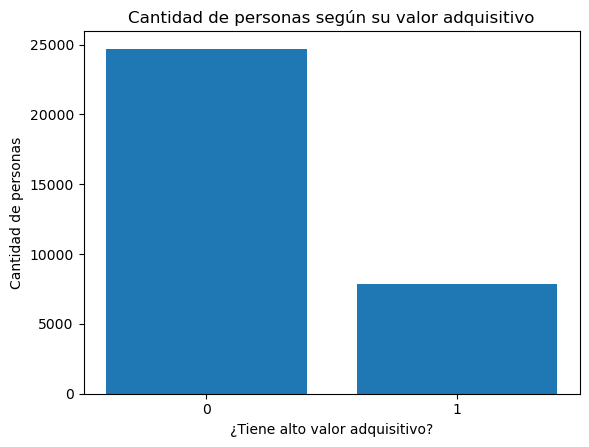

In [4]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_ingresos = (df['tiene_alto_valor_adquisitivo'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_ingresos.index, personas_por_ingresos.values)
plt.ylabel("Cantidad de personas")
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.xticks(ticks=[0,1])
plt.title('Cantidad de personas según su valor adquisitivo')
plt.show()

Se puede ver que solo tiene dos valores disponibles que son 0 y 1 como necesitamos.

Luego, utilizando el metodo value_counts en cada columna revisamos que no hayan campos vacios, con guiones u otros valores que significan que no hay algo completo.
Después de verificar cada columna, vimos que esto no sucede en ninguna.

A continuación, observemos la cantidad de valores nulos para cada feature. Hay valores nulos en las columas 'barrio', 'categoria_de_trabajo' y 'trabajo' como habiamos visto anteriormente.


In [5]:
dfNulos = pd.DataFrame({'Cantidad de nulos': df.isnull().sum(), 'Porcentaje de nulos': (df.isnull().mean() * 100)})
dfNulos

,Cantidad de nulos,Porcentaje de nulos
anios_estudiados,0,0.000000
barrio,583,1.790486
categoria_de_trabajo,1836,5.638647
edad,0,0.000000
educacion_alcanzada,0,0.000000
estado_marital,0,0.000000
ganancia_perdida_declarada_bolsa_argentina,0,0.000000
genero,0,0.000000
horas_trabajo_registradas,0,0.000000
religion,0,0.000000


Si hacemos un análisis de los valores nulos en las columnas categoría de trabajo y trabajo, podemos encontrar una relación entre estas

In [6]:
trabajo_y_categoria_na = df[df['categoria_de_trabajo'].isna() & df['trabajo'].isna()]
print(f"Hay {len(trabajo_y_categoria_na)} filas con valores nulos en trabajo y categoría")


Hay 1836 filas con valores nulos en trabajo y categoría


Si miramos los números anteriores, se puede ver que la totalidad de los registros que tienen categoria de trabajo "NaN", tambien tienen trabajo "NaN". Luego, hay 7 registros que tienen trabajo "NaN", pero su categoría de trabajo no. Como vemos a continuación, esos 7 registros tienen como categoría de trabajo "sin_trabajo".

In [7]:
desempleados = df[(df['trabajo'].isna()) & (df['categoria_de_trabajo'] == 'sin_trabajo')]
desempleados[['categoria_de_trabajo', 'trabajo', 'tiene_alto_valor_adquisitivo']]

,categoria_de_trabajo,trabajo,tiene_alto_valor_adquisitivo
5361,sin_trabajo,NaN,0
10845,sin_trabajo,NaN,0
14772,sin_trabajo,NaN,0
20337,sin_trabajo,NaN,0
23232,sin_trabajo,NaN,0
32304,sin_trabajo,NaN,0
32314,sin_trabajo,NaN,0


Estos registros representan gente sin trabajo, que además no tiene alto valor adquisitivo. Creemos conveniente agruparlos en un mismo campo de trabajo, llamado "desempleado".

In [8]:
df['trabajo'] = np.where(df['categoria_de_trabajo'] == 'sin_trabajo', 'desempleado', df['trabajo'])
df.reset_index(drop=True, inplace=True)
dfNulos = pd.DataFrame({'Cantidad de nulos': df.isnull().sum()})
dfNulos

,Cantidad de nulos
anios_estudiados,0
barrio,583
categoria_de_trabajo,1836
edad,0
educacion_alcanzada,0
estado_marital,0
ganancia_perdida_declarada_bolsa_argentina,0
genero,0
horas_trabajo_registradas,0
religion,0


Vamos a enfocarnos ahora en analizar los ingresos de las 1836 personas con categoría de trabajo y trabajo "NaN", para determinar si son verdaderamente ruido, o se pueden estar escapando datos importantes.

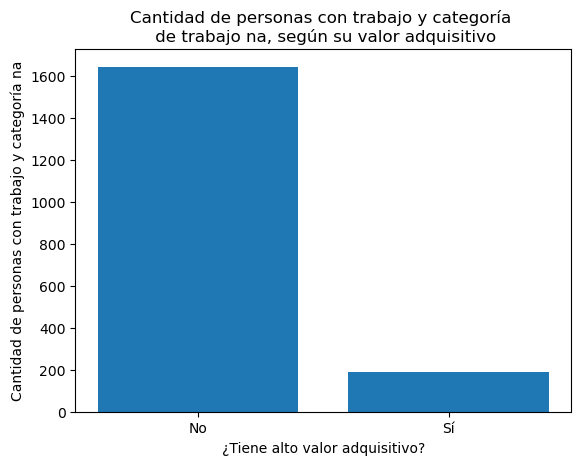

In [9]:
trabajo_y_categoria_na = df[df['categoria_de_trabajo'].isna() & df['trabajo'].isna()]
plt.figure(figsize=(6.4, 4.8), dpi=100)
trabajo_y_categoria_na_por_ingresos = (
    trabajo_y_categoria_na['tiene_alto_valor_adquisitivo']
    .value_counts()
    .sort_values(ascending=False)
)
plt.bar(trabajo_y_categoria_na_por_ingresos.index, trabajo_y_categoria_na_por_ingresos.values)
plt.ylabel("Cantidad de personas con trabajo y categoría na")
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.xticks(ticks=[0,1], labels=['No', 'Sí'])
plt.title('Cantidad de personas con trabajo y categoría \n de trabajo na, según su valor adquisitivo')
plt.show()

Como se puede ver, hay alrededor de 200 contribuyentes que tienen valores nulos en su trabajo y categoría de trabajo. Esto representa, aproximadamente, un 2,5% de las personas que tienen alto valor adquisitivo. Es decir, son alrededor de 200 posibles evasores. 

Creemos que quizás eliminar estas filas resulte en una pérdida significativa para FIUFIP, por lo que decidimos conservarlas. Para ello, creamos un nuevo valor "No responde" tanto para la categoría de trabajo como para el trabajo, y los colocamos allí.

In [10]:
df[df['categoria_de_trabajo'] == 'monotibutista'].tiene_alto_valor_adquisitivo.value_counts()

0    1817
1     724
Name: tiene_alto_valor_adquisitivo, dtype: int64

In [11]:
trabajo_y_categoria_na.tiene_alto_valor_adquisitivo.value_counts()

0    1645
1     191
Name: tiene_alto_valor_adquisitivo, dtype: int64

In [12]:
df = df.replace(np.nan, {'categoria_de_trabajo': 'no_responde', 'trabajo': 'no_responde'})
df.reset_index(drop=True, inplace=True)
dfNulos = pd.DataFrame({'Cantidad de nulos': df.isnull().sum()})
dfNulos

,Cantidad de nulos
anios_estudiados,0
barrio,583
categoria_de_trabajo,0
edad,0
educacion_alcanzada,0
estado_marital,0
ganancia_perdida_declarada_bolsa_argentina,0
genero,0
horas_trabajo_registradas,0
religion,0


Por último, vamos a revisar los valores "NaN" en la categoría barrio, según los ingresos. 

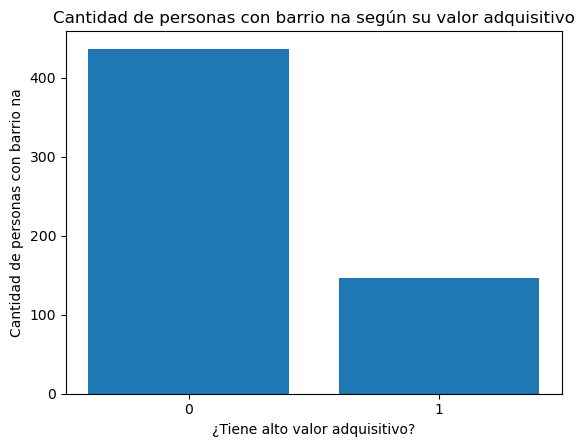

In [13]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_con_barrio_na_segun_ingresos = (
    df[df['barrio'].isna()]
    .tiene_alto_valor_adquisitivo
    .value_counts()
    .sort_values(ascending=False)
)
plt.bar(personas_con_barrio_na_segun_ingresos.index, personas_con_barrio_na_segun_ingresos.values)
plt.ylabel("Cantidad de personas con barrio na")
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.xticks(ticks=[0,1])
plt.title('Cantidad de personas con barrio na según su valor adquisitivo')
plt.show()

En este caso, ocurre algo similar que con los registros que tenían "NaN" en trabajo y categoría, ya que pareciera ser que un porcentaje significativo de personas con alto valor adquisitivo, tiene "NaN" en su barrio. Aproximadamente, se trata de 150 personas, lo que representa alrededor de un 2% sobre el total de contribuyentes con altos ingresos. 

Por lo tanto, los valores "NaN" de la categoría barrio, decidimos reemplazarlos con un valor llamado 'No responde'.

In [14]:
df = df.replace(np.nan, {'barrio': 'No responde'})
df.reset_index(drop=True, inplace=True)
dfNulos = pd.DataFrame({'Cantidad de nulos': df.isnull().sum()})
dfNulos

,Cantidad de nulos
anios_estudiados,0
barrio,0
categoria_de_trabajo,0
edad,0
educacion_alcanzada,0
estado_marital,0
ganancia_perdida_declarada_bolsa_argentina,0
genero,0
horas_trabajo_registradas,0
religion,0


Podemos ver que ya no tenemos registros con valores nulos.


Por último,vamos a revisar que las columnas no numéricas que deberían contener solo caracteres, contengan lo que deberían contener. Obviamos la columna educacion_alcanzada, ya que esta puede tener números.

In [15]:
columnas_no_numericas = ['barrio', 'categoria_de_trabajo', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']
for c in columnas_no_numericas:
    print(df[c].str.contains('1|2|3|4|5|6|7|8|9|0|-|#|%|&|!|@').any())      

False
False
False
False
False
False
False


Una vez limpio el dataset, podemos continuar con el análisis de los datos.

## Análisis de los datos

Para hacer el análisis del set de datos, primero vamos a realizarnos unas preguntas simples a modo de guía, para hacer un desarrollo a partir de estas. Las preguntas que surgieron en este caso son:

- ¿Está el barrio en el que residen las personas relacionado con sus ingresos?
- Las personas con altos ingresos, ¿Son en su mayoría hombres o mujeres?
- ¿En qué afecta el nivel de educación alcanzada?
- ¿El estado marital influye en nuestra variable objetivo?
- ¿Si un contribuyente declara ganancia/pérdida en la bolsa, afecta esto fuertemente sus ingresos?
- ¿La cantidad de años estudiados es un factor influyente?
- ¿Se debería tener en cuenta la religión?
- ¿Influye la edad en los ingresos de la persona?
- ¿Es el rol familiar registrado determinante en los ingresos de las personas?
- ¿Es influyente la categoría de trabajo?
- ¿Es el tipo de trabajo un factor fundamental para determinar los ingresos de una persona?
- ¿La cantidad de horas trabajadas influye en el valor adquisitivo de la gente?

## ¿En qué afecta el nivel de educación alcanzada?

Para ver esta relación, decidimos separar a la población en categorías según el nivel educativo alcanzado. Siendo estos "Universitario", "Secundario", "Primario" y "Jardin".

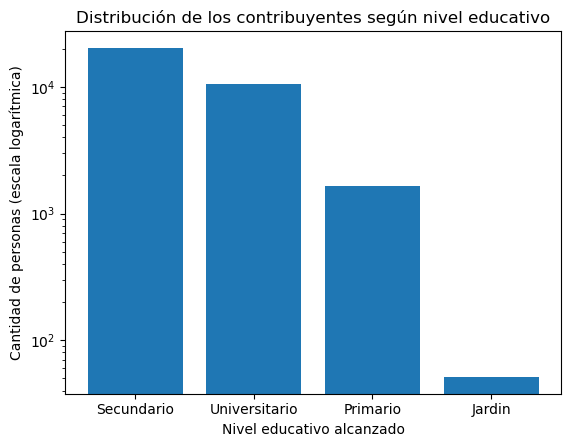

In [16]:
def definir_nivel(nivel):
    if nivel.startswith("uni"):
        return "Universitario"
    elif nivel.endswith("anio"):
        return "Secundario"
    elif nivel.endswith("grado"):
        return "Primario"
    else:
        return "Jardin"

df['nivel_educativo_alcanzado'] = df['educacion_alcanzada'].apply(definir_nivel)

plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_nivel_educativo = (df['nivel_educativo_alcanzado'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_nivel_educativo.index, personas_por_nivel_educativo.values)
plt.yscale("log")
plt.ylabel("Cantidad de personas (escala logarítmica)")
plt.xlabel("Nivel educativo alcanzado")
plt.title("Distribución de los contribuyentes según nivel educativo")
plt.show()

Elegimos un gráfico con escala logarítmica, para que se pueda visualizar la cantidad de gente de jardín, ya que con una escala lineal no se podía apreciar correctamente.

Como se puede ver, la mayoría de los contribuyentes alcanzaron una educación de nivel secundario y universitario.
A continuación, vamos a analizar el nivel educativo según el valor adquisitivo.

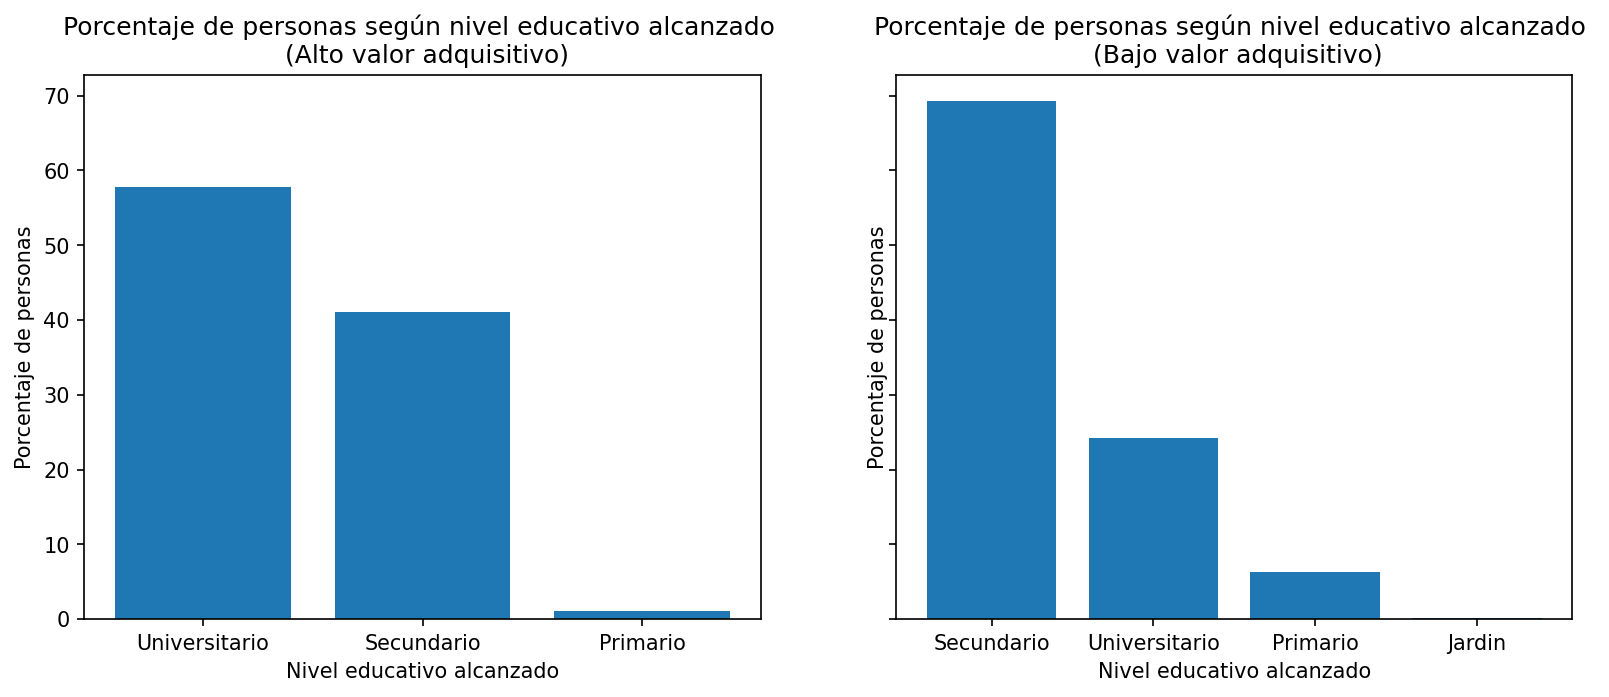

In [17]:
alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
bajo_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 0]

porcentaje_alto_valor_adquisitivo = (
    alto_valor_adquisitivo.nivel_educativo_alcanzado.value_counts() / 
    len(alto_valor_adquisitivo) * 100
)
porcentaje_bajo_valor_adquisitivo = (
    bajo_valor_adquisitivo.nivel_educativo_alcanzado.value_counts() / 
    len(bajo_valor_adquisitivo) * 100
)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=150, figsize=(6.4 * 2, 4.8))

axes[0].bar(porcentaje_alto_valor_adquisitivo.index, porcentaje_alto_valor_adquisitivo.values)
axes[0].set_title("Porcentaje de personas según nivel educativo alcanzado \n (Alto valor adquisitivo)")
axes[0].set_xlabel("Nivel educativo alcanzado")
axes[0].set_ylabel("Porcentaje de personas")

axes[1].bar(porcentaje_bajo_valor_adquisitivo.index, porcentaje_bajo_valor_adquisitivo.values)
axes[1].set_title("Porcentaje de personas según nivel educativo alcanzado \n (Bajo valor adquisitivo)")
axes[1].set_xlabel("Nivel educativo alcanzado")
axes[1].set_ylabel("Porcentaje de personas")

plt.show()

Se observa a simple vista que la mayoría de las personas con altos ingresos tienen nivel educativo universitario, con gran cantidad de personas con estudios secundarios. Mientras que en las personas con bajos ingresos, se puede ver que la mayoría son personas con estudios secundarios, pero en este caso la población universitaria no es tan significativa como en el caso anterior.
Además, se visualiza que disminuye mucho la cantidad de personas con estudios primarios y jardín, esta última no tiene ningun caso con alto valor adquisitivo.

Por lo tanto, creemos que puede llegar a haber una relación entre el nivel educativo y los altos ingresos.

## ¿El estado marital influye en nuestra variable objetivo?

Para ver esta relación primero decidimos ver cómo se distribuye la variable en nuestra poblacion:

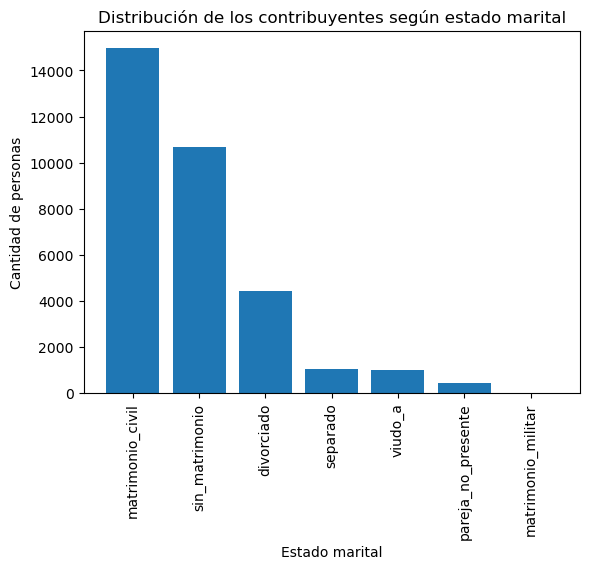

In [18]:
df.estado_marital.value_counts()

plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_estado_marital = (df['estado_marital'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_estado_marital.index, personas_por_estado_marital.values)
plt.ylabel("Cantidad de personas")
plt.xlabel("Estado marital")
plt.xticks(rotation=90)
plt.title("Distribución de los contribuyentes según estado marital")
plt.show()

Pasamos a ver ahora la distribución del estado marital según el valor adquisitivo de las personas.

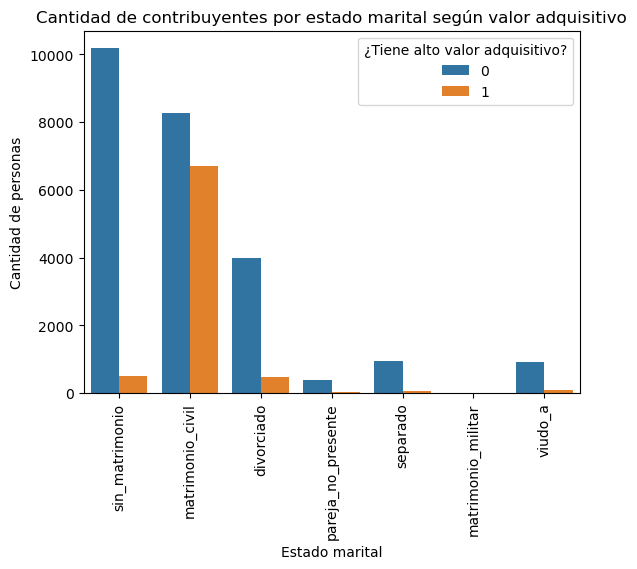

In [19]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
sns.countplot(data=df, x='estado_marital', hue='tiene_alto_valor_adquisitivo')
plt.title("Cantidad de contribuyentes por estado marital según valor adquisitivo")
plt.ylabel("Cantidad de personas")
plt.xlabel("Estado marital")
plt.xticks(rotation=90)
plt.legend(title="¿Tiene alto valor adquisitivo?")
plt.show()

In [20]:
personas_con_matrimonio_militar = (df.estado_marital.value_counts().matrimonio_militar)
print(f"Hay {personas_con_matrimonio_militar} personas con matrimonio militar")


Hay 23 personas con matrimonio militar


Como se puede ver, las personas que tienen matrimonio_militar, son bastante pocas, concretamente 23. Debido a esto, decidimos unificar las categorías "matrimonio_civil" y "matrimonio_militar" en una categoría llamada "Con matrimonio", para no hacer una distinción de matrimonios solamente por ese bajo número de personas. Por el gráfico que se encuentra a continuación, queda claro que ambas categorías tienen una distribución similar en cuanto a la variable target.

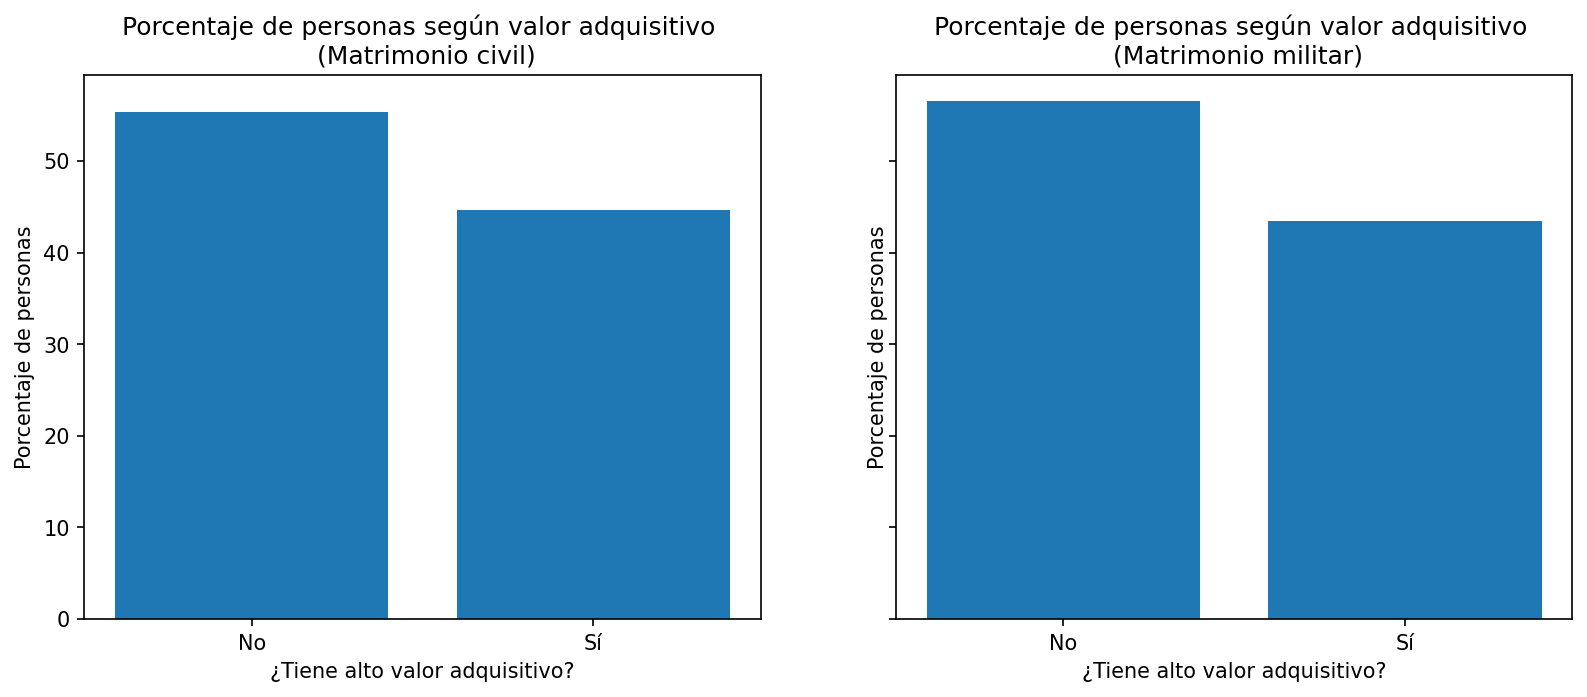

In [21]:
matrimonio_civil = df[df['estado_marital'] == 'matrimonio_civil']
matrimonio_militar = df[df['estado_marital'] == 'matrimonio_militar']

porcentaje_matrimonio_civil = (
    matrimonio_civil.tiene_alto_valor_adquisitivo.value_counts() / 
    len(matrimonio_civil) * 100
)
porcentaje_matrimonio_militar = (
    matrimonio_militar.tiene_alto_valor_adquisitivo.value_counts() / 
    len(matrimonio_militar) * 100
)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=150, figsize=(6.4 * 2, 4.8))

axes[0].bar(porcentaje_matrimonio_civil.index, porcentaje_matrimonio_civil.values)
axes[0].set_title("Porcentaje de personas según valor adquisitivo \n (Matrimonio civil)")
axes[0].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[0].set_ylabel("Porcentaje de personas")
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(['No', 'Sí'])

axes[1].bar(porcentaje_matrimonio_militar.index, porcentaje_matrimonio_militar.values)
axes[1].set_title("Porcentaje de personas según valor adquisitivo \n (Matrimonio militar)")
axes[1].set_xlabel("¿Tiene alto valor adquisitivo?")
axes[1].set_ylabel("Porcentaje de personas")
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(['No', 'Sí'])



plt.show()

Además, según el gráfico anterior a este, las personas pertenecientes al resto de las categorías poseen una distribución similar entre sí, en cuanto a su valor adquisitivo. Viendo los nombres de estas, nos damos cuenta de que representan a los contribuyentes que no están con otra persona para la ley. Por lo tanto, consideramos correcto agrupar estas también, pero en una categoría llamada "Sin matrimonio".

De esta manera, nos quedaría una nueva columna, llamada "tiene_matrimonio", que contiene los valores "Con matrimonio" y "Sin matrimonio".

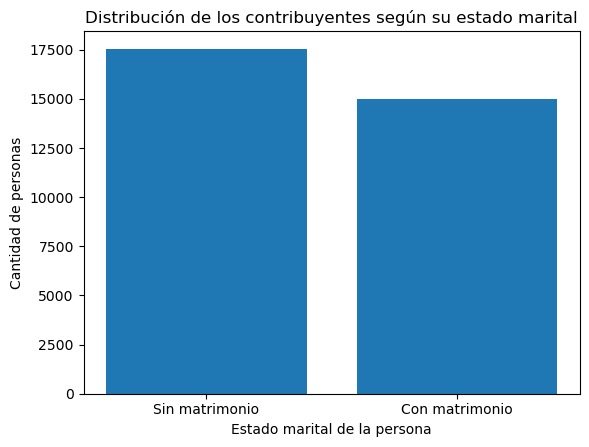

In [22]:
def definir_estado_marital(estado_marital):
    if estado_marital.startswith('matrimonio'):
        return 'Con matrimonio'
    else:
        return 'Sin matrimonio'
    
df['tiene_matrimonio'] = df['estado_marital'].apply(definir_estado_marital)

plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_estado_marital = (df['tiene_matrimonio'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_estado_marital.index, personas_por_estado_marital.values)
plt.ylabel("Cantidad de personas")
plt.xlabel("Estado marital de la persona")
plt.title("Distribución de los contribuyentes según su estado marital")
plt.show()

Como se puede ver en el gráfico, nuestra población esta dividida casi de forma equitativa entre los que tienen matrimonio y los que no, siendo estos últimos mayoría por un pequeño margen.

A continuación, revisamos cómo se relaciona esto con nuestra variable target:

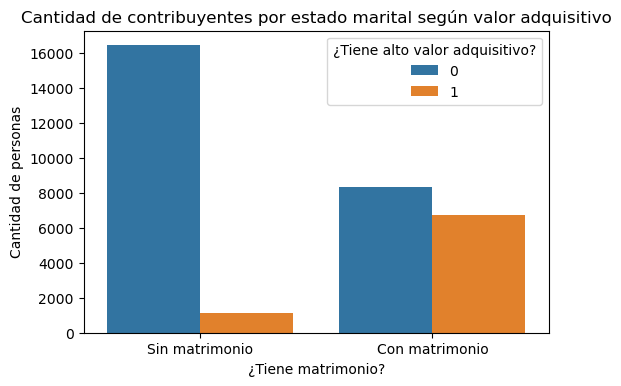

In [23]:
personas_con_alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
plt.figure(dpi=100)
sns.countplot(data=df, x='tiene_matrimonio', hue='tiene_alto_valor_adquisitivo')
plt.title("Cantidad de contribuyentes por estado marital según valor adquisitivo")
plt.ylabel("Cantidad de personas")
plt.xlabel("¿Tiene matrimonio?")
plt.legend(title="¿Tiene alto valor adquisitivo?")
plt.show()

Se puede observar que existe una relación entre el nivel de ingresos y el estado marital de las personas. La mayoría de las personas sin matrimonio son de ingresos bajos, mientras que en la población con matrimonio se distribuye casi de forma equitativa.
Además como conclusión, en nuestra variable target, la mayoría de las personas contrajeron matrimonio. Lo mostramos en el siguiente gráfico:

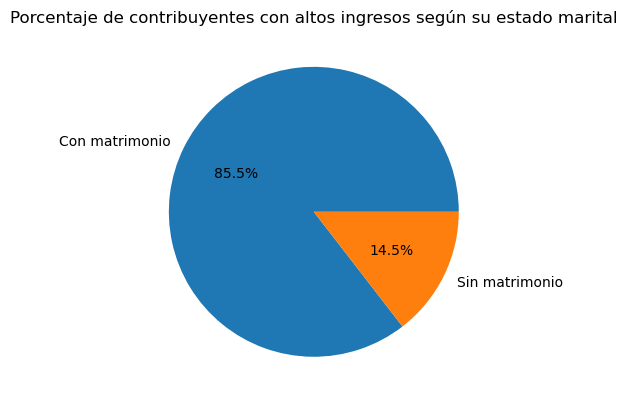

In [24]:
personas_con_alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_con_alto_valor_adquisitivo.tiene_matrimonio.value_counts().plot(kind='pie', autopct='%.01f%%')
plt.title('Porcentaje de contribuyentes con altos ingresos según su estado marital')
plt.ylabel("")
plt.show()

## ¿Si un contribuyente declara ganancia/pérdida en la bolsa, afecta esto fuertemente sus ingresos?


Analizamos primero un histograma de los resultados en la bolsa de la población en general. Para ello, creemos conveniente segmentar este feature en las categorías: ganancia, pérdida y cero, para ver cómo está distribuido. A partir de estas comenzamos el análisis.

In [25]:
def definir_resultado_en_bolsa(resultado_en_bolsa):
    if resultado_en_bolsa > 0:
        return 'Ganancia'
    elif resultado_en_bolsa < 0:
        return 'Pérdida'
    else:
        return 'Cero'
    
df['resultado_en_bolsa_argentina'] = df['ganancia_perdida_declarada_bolsa_argentina'].apply(definir_resultado_en_bolsa)

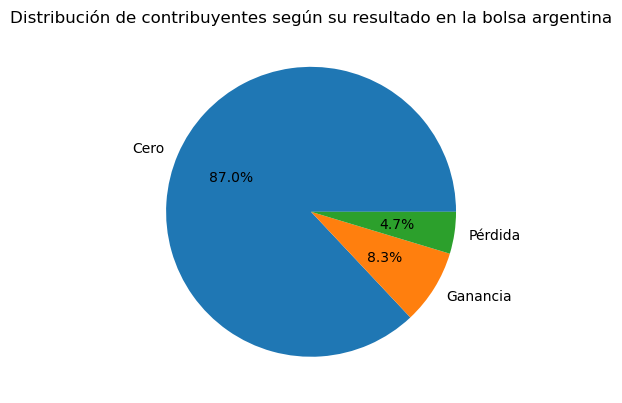

In [26]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
df['resultado_en_bolsa_argentina'].value_counts().plot(kind='pie', autopct='%.01f%%')
plt.title('Distribución de contribuyentes según su resultado en la bolsa argentina')
plt.ylabel("")
plt.show()

Como se puede observar, es clara la predominancia del cero, por lo que la gran mayoría de la población no tuvo ni ganancias ni pérdidas en la bolsa argentina. Decidimos ver si las ganancias y las pérdidas tienen alguna correlación con nuestra variable objetivo, por lo que dejamos a las personas con resultado "Cero" fuera del análisis.

Comenzamos analizando las ganancias en la bolsa.

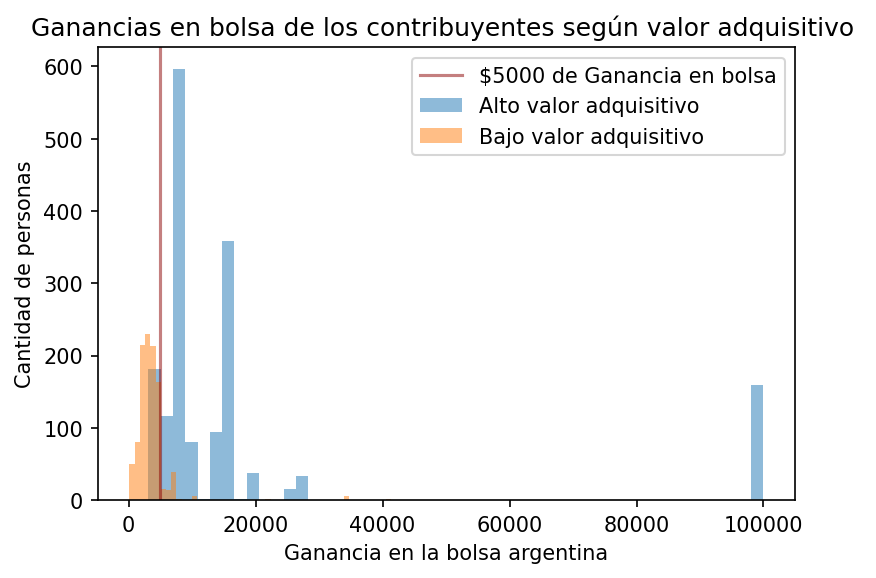

In [27]:
alto_valor_adquisitivo = df[(df['tiene_alto_valor_adquisitivo'] == 1) & (df['ganancia_perdida_declarada_bolsa_argentina'] > 0)]
bajo_valor_adquisitivo = df[(df['tiene_alto_valor_adquisitivo'] == 0) & (df['ganancia_perdida_declarada_bolsa_argentina'] > 0)]
plt.figure(dpi=150)
plt.hist(
    alto_valor_adquisitivo['ganancia_perdida_declarada_bolsa_argentina'],
    label="Alto valor adquisitivo",
    bins=50,
    alpha=0.5

)
plt.hist(
    bajo_valor_adquisitivo['ganancia_perdida_declarada_bolsa_argentina'],
    label="Bajo valor adquisitivo",
    bins=50,
    alpha=0.5
)
plt.title("Ganancias en bolsa de los contribuyentes según valor adquisitivo ")
plt.xlabel("Ganancia en la bolsa argentina")
plt.ylabel("Cantidad de personas")
plt.axvline(x=5000, color="darkred", label="$5000 de Ganancia en bolsa", alpha=0.5)
plt.legend()

plt.show()

Podemos ver que hay una evidente división entre los que tienen altos ingresos y los que no. Esta se encuentra aproximadamente a partir de los $5000 de ganancia. Esto es un factor interesante para la predicción del alto valor adquisitivo.

A continuación, analizamos las pérdidas en la bolsa argentina.

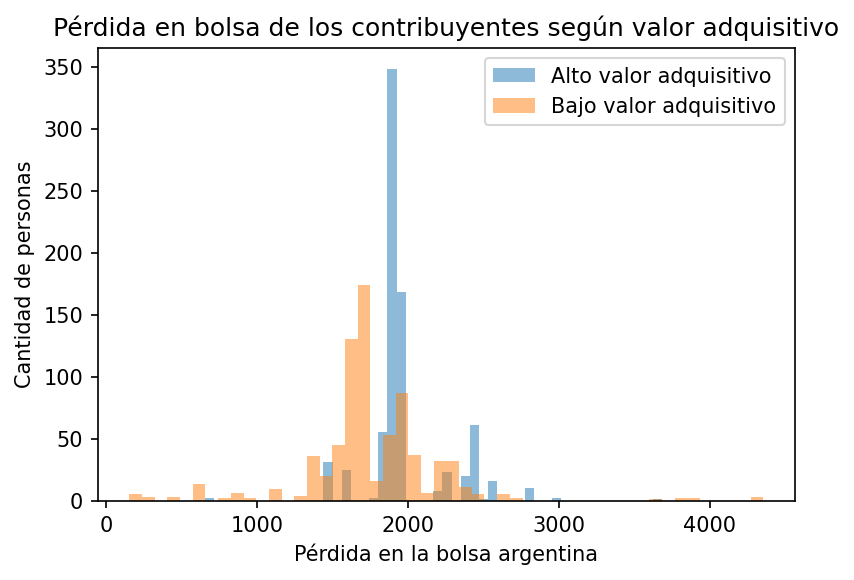

In [28]:
alto_valor_adquisitivo = df[(df['tiene_alto_valor_adquisitivo'] == 1) & (df['ganancia_perdida_declarada_bolsa_argentina'] < 0)]
bajo_valor_adquisitivo = df[(df['tiene_alto_valor_adquisitivo'] == 0) & (df['ganancia_perdida_declarada_bolsa_argentina'] < 0)]
plt.figure(dpi=150)
plt.hist(
    alto_valor_adquisitivo['ganancia_perdida_declarada_bolsa_argentina'].abs(),
    label="Alto valor adquisitivo",
    bins=50,
    alpha=0.5
)
plt.hist(
    bajo_valor_adquisitivo['ganancia_perdida_declarada_bolsa_argentina'].abs(),
    label="Bajo valor adquisitivo",
    bins=50,
    alpha=0.5
)
plt.title("Pérdida en bolsa de los contribuyentes según valor adquisitivo")
plt.xlabel("Pérdida en la bolsa argentina")
plt.ylabel("Cantidad de personas")
plt.legend()

plt.show()

En este caso, a diferencia del anterior, no se tiene una clara distinción entre los dos grupos, por lo que no vamos a tomar en cuenta el factor pérdida en la bolsa para el análisis.

## ¿La cantidad de años estudiados es un factor influyente?

Vamos a visualizar primero cómo se distribuye la variable "anios_estudiados" dentro de la población.

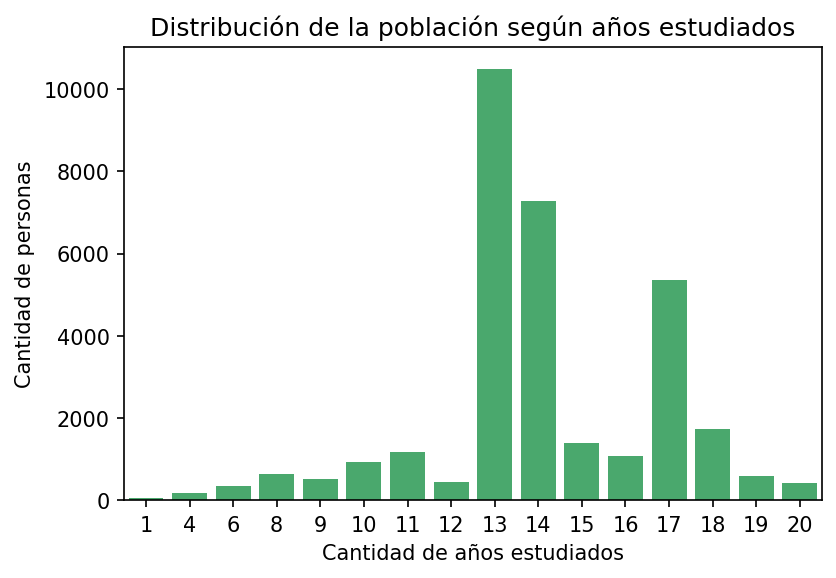

In [29]:
plt.figure(dpi=150)
sns.countplot(data=df, x='anios_estudiados', color=(0.23, 0.72, 0.41))
plt.title("Distribución de la población según años estudiados")
plt.xlabel("Cantidad de años estudiados")
plt.ylabel("Cantidad de personas")
plt.show()

Decidimos ver a continuación si existe alguna relación entre la cantidad de años estudiados y nuestra variable target. Para ello, creemos conveniente agrupar en categorías. Los valores hasta los 10 años los agrupamos en una misma categoría, y el resto los dejamos específicos por año.

Text(0.5, 1.0, 'Cantidad de personas por años estudiados según su nivel de ingresos')

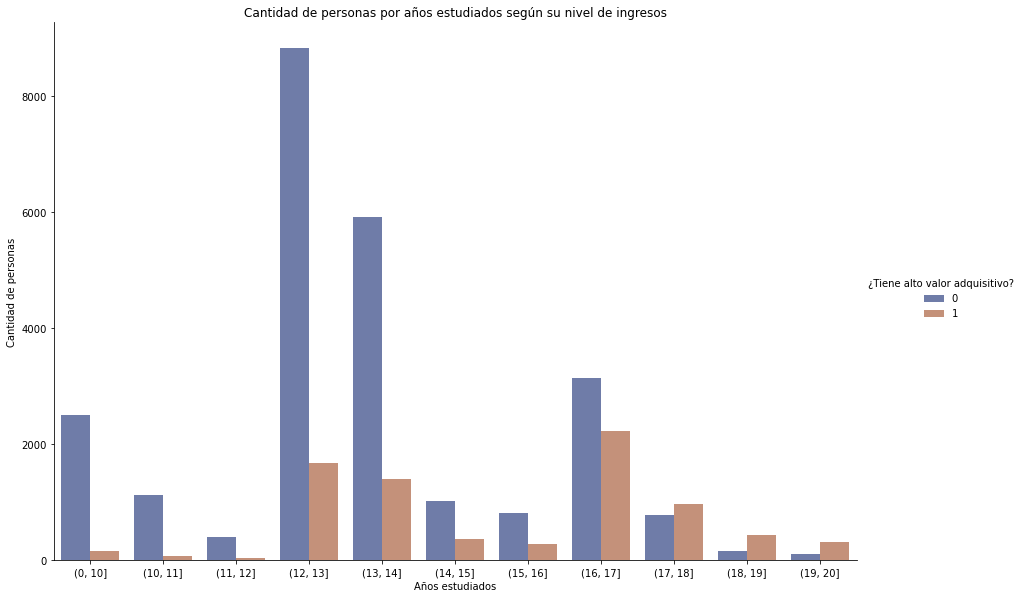

In [30]:
bins = [0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
categorias_anios = pd.cut(df['anios_estudiados'], bins=bins)

tipo_ingresos_por_anios_estudiados = df.groupby(by=categorias_anios)['tiene_alto_valor_adquisitivo'].value_counts()
df_aux = tipo_ingresos_por_anios_estudiados.to_frame()
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de personas'},inplace=True)
df_aux.reset_index(inplace=True)
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'¿Tiene alto valor adquisitivo?','anios_estudiados':'Años estudiados'},inplace=True)

sns.catplot(
    data=df_aux, kind="bar",
    x="Años estudiados", y="Cantidad de personas", hue="¿Tiene alto valor adquisitivo?",
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Cantidad de personas por años estudiados según su nivel de ingresos")

Se puede observar que la mayor cantidad de personas que tienen bajo nivel adquisitivo tienen 14 o menos años de estudio. A su vez, la mayoria de personas con altos ingresos tienen 14 o más años de estudio. Decidimos mostrar esto en el siguiente gráfico:

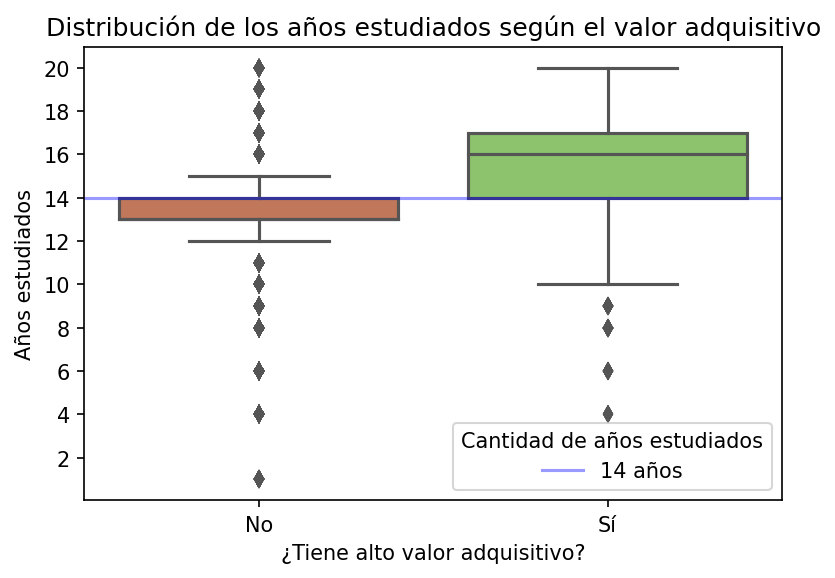

In [31]:
plt.figure(dpi=150)
plt.title("Distribución de los años estudiados según el valor adquisitivo")
sns.boxplot(
    data=df,
    y='anios_estudiados',
    x='tiene_alto_valor_adquisitivo',
    palette=['#D17049', "#89D15E"]
)
plt.ylabel("Años estudiados")
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.xticks([False, True], ["No", "Sí"])
plt.yticks(np.arange(2, 22, 2).tolist())
plt.axhline(y=14, color="blue", label="14 años", alpha=0.4)
plt.legend(title="Cantidad de años estudiados")
plt.show()

La línea graficada corresponde con los 14 años de estudio.
Se puede ver con claridad que el cuantil 75(Q3) de la población con bajo valor adquisitivo se encuentra sobre esta línea, mientras que el cuantil 25(Q1) de la población con alto valor adquisitivo se encuentra sobre la misma. Por lo tanto, la mayoría de la población con alto valor adquisitivo tiene más de 14 años de estudios.

Por lo tanto, la cantidad de años estudiados es un factor influyente en los ingresos de los contribuyentes.


## ¿Influye la edad en los ingresos de la persona?

Primero comenzamos viendo como se distribuye la edad en nuestra población según sus niveles de ingreso.

Decidimos agrupar las edades en categorías para lograr una mejor interpretación de las mismas, ya que son demasiados valores diferentes para un gráfico.

Text(0.5, 1.0, 'Cantidad de personas por edad según su nivel de ingresos')

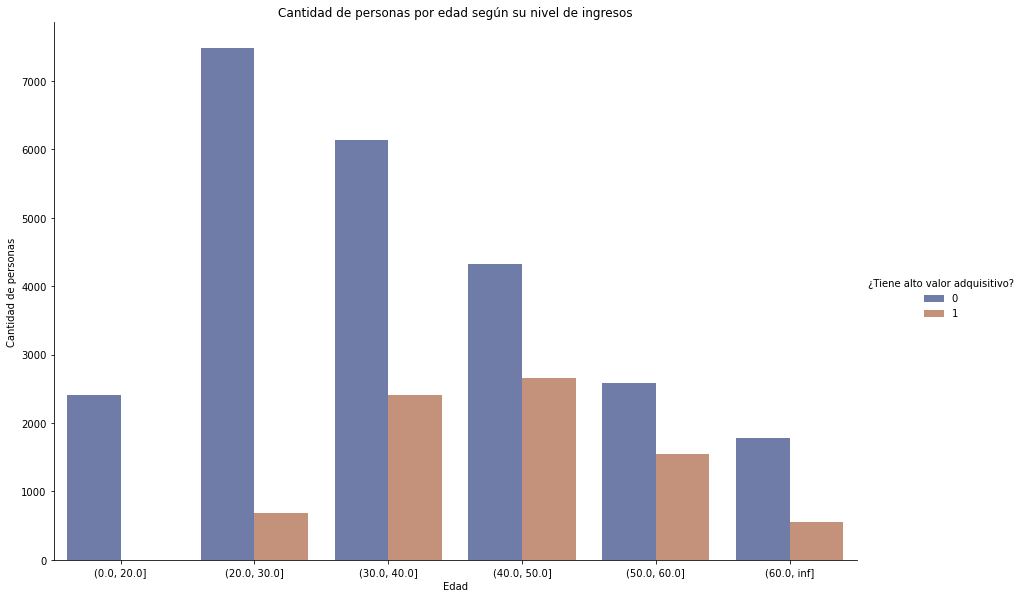

In [32]:
bins = [0, 20, 30, 40, 50, 60, np.inf]
edades = pd.cut(df['edad'], bins=bins)

tipo_ingresos_por_edad = df.groupby(by=edades)['tiene_alto_valor_adquisitivo'].value_counts()
df_aux = tipo_ingresos_por_edad.to_frame()
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de personas'}, inplace=True)
df_aux.reset_index(inplace=True)
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'¿Tiene alto valor adquisitivo?','edad':'Edad'},inplace=True)

sns.catplot(
    data=df_aux, kind="bar",
    x="Edad", y="Cantidad de personas", hue="¿Tiene alto valor adquisitivo?",
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Cantidad de personas por edad según su nivel de ingresos")

Es evidente que pasados los 30 años de edad se encuentra la mayor cantidad de personas con alto valor adquisitivo. También se observa que los menores o iguales a 30 años poseen una gran cantidad de personas con valor adquisitivo bajo. Ambas relaciones pueden llegar a ser importantes para el análisis.

## ¿Es el rol familiar registrado determinante en los ingresos de las personas?

Para determinarlo, vamos a ver la distribución de la población en general, según su rol familiar.

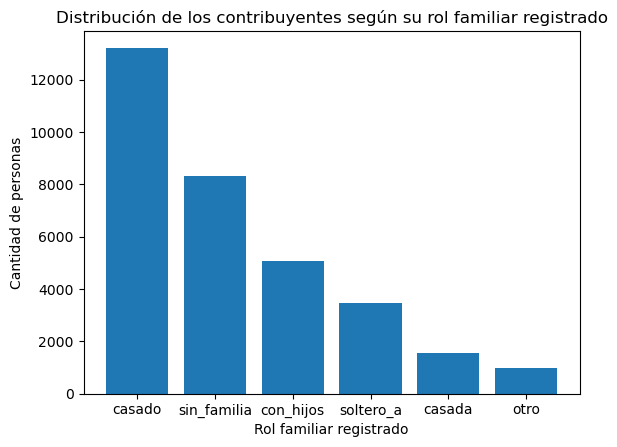

In [33]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_rol_familiar = (df['rol_familiar_registrado'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_rol_familiar.index, personas_por_rol_familiar.values)
plt.ylabel("Cantidad de personas")
plt.xlabel("Rol familiar registrado")
plt.title("Distribución de los contribuyentes según su rol familiar registrado")
plt.show()

Creemos conveniente agrupar las categorías casado y casada en una misma, llamada "casado_a".

In [34]:
df = df.replace({'rol_familiar_registrado':'casado'}, {'rol_familiar_registrado':'casado_a'})
df = df.replace({'rol_familiar_registrado':'casada'}, {'rol_familiar_registrado':'casado_a'})

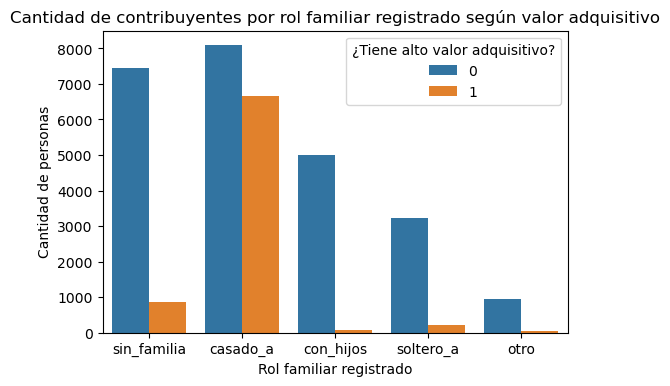

In [35]:
plt.figure(dpi=100)
sns.countplot(data=df, x='rol_familiar_registrado', hue='tiene_alto_valor_adquisitivo')
plt.title("Cantidad de contribuyentes por rol familiar registrado según valor adquisitivo")
plt.ylabel("Cantidad de personas")
plt.xlabel("Rol familiar registrado")
plt.legend(title="¿Tiene alto valor adquisitivo?")
plt.show()

Se puede observar que los contribuyentes con alto valor adquisitivo tienen, en su mayoría, el rol familiar casado_a. Los resultados son los esperados ya que habíamos encontrado resultados similares en el estado marital, donde la mayoría de las personas con alto valor adquisitivo tenían matrimonio.



## Relación entre estado marital y cantidad de años estudiados

Luego de lo visto en el análisis individual, llegamos a la conclusión de que ambas variables parecían ser importantes para definir el valor adquisitivo de las personas. Como ambas parecen importantes, decidimos ver si existe una relación entre ellas. Para esto, creemos conveniente poner en categorías los años estudiados, ya que teníamos muchos valores separados, y en el análisis de esta categoría vimos que existian ciertos estratos que nos interesaban, sobre todo la división en los 14 años de estudio. A su vez, en lugar de analizar el estado marital, decidimos utilizar las categorías que ya habíamos visto para el analisis individual, que llamamos 'Con matrimonio' y 'Sin matrimonio'.

In [36]:
def determinar_rango_anios_estudiados(anios):
    if anios < 12:
        return 'Menos de 12'
    elif (anios >= 12) & (anios <= 14):
        return 'De 12 a 14'
    elif (anios > 14) & (anios <= 17):
        return 'De 15 a 17'
    else:
        return 'Más de 17'

df['rango_anios_estudiados'] = df['anios_estudiados'].apply(determinar_rango_anios_estudiados)

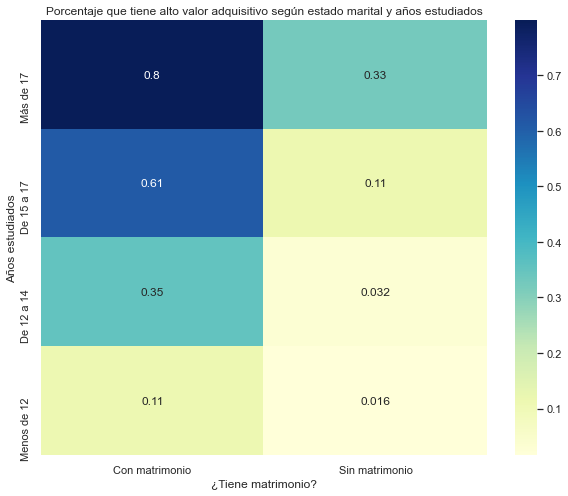

In [37]:
sns.set(rc={'figure.figsize':(10,8)})
estado_marital_anios_estudiados = pd.pivot_table(data = df, index = 'rango_anios_estudiados', values = 'tiene_alto_valor_adquisitivo', columns = 'tiene_matrimonio')
estado_marital_anios_estudiados.sort_index(ascending =  False, inplace = True)
estado_marital_anios_estudiados = estado_marital_anios_estudiados.reindex( ['Más de 17','De 15 a 17','De 12 a 14','Menos de 12'],axis = 0)

mascara = estado_marital_anios_estudiados.isnull()
g = sns.heatmap(estado_marital_anios_estudiados, mask = mascara, cmap="YlGnBu", annot=True)
g.set_ylabel("Años estudiados")
g.set_xlabel("¿Tiene matrimonio?")
g.set_title("Porcentaje que tiene alto valor adquisitivo según estado marital y años estudiados")

plt.show()

Se puede observar una clara relación entre la cantidad de años de estudio y el hecho de tener matrimonio. A partir de los 15 años de estudio, las personas con matrimonio tienen en su mayoría alto poder adquisitivo.

## Relación entre edad, estado marital y años de estudio

Como vimos en el analisis anterior, existe una relación entre el estado marital y los años de estudio. Decidimos analizar las mismas categorias que antes, pero ahora utilizando un dataframe que únicamente tiene a los mayores de 30 años. Hacemos esto, debido a que al analizar la categoría 'edad' vimos que hay una gran cantidad de personas menores a los 30 años que tienen bajo valor adquisitivo.

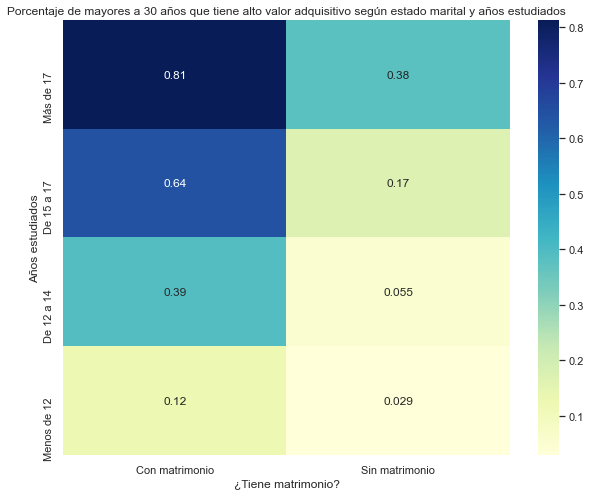

In [38]:
sns.set(rc={'figure.figsize':(10,8)})
estado_marital_anios_estudiados = pd.pivot_table(data = df[df['edad']>30], index = 'rango_anios_estudiados', values = 'tiene_alto_valor_adquisitivo', columns = 'tiene_matrimonio')
estado_marital_anios_estudiados.sort_index(ascending =  False, inplace = True)
estado_marital_anios_estudiados = estado_marital_anios_estudiados.reindex( ['Más de 17','De 15 a 17','De 12 a 14','Menos de 12'],axis = 0)

mascara = estado_marital_anios_estudiados.isnull()
g = sns.heatmap(estado_marital_anios_estudiados, mask = mascara, cmap="YlGnBu", annot=True)
g.set_ylabel("Años estudiados")
g.set_xlabel("¿Tiene matrimonio?")
g.set_title("Porcentaje de mayores a 30 años que tiene alto valor adquisitivo según estado marital y años estudiados")

plt.show()

Se puede observar una mejora en los porcentajes de personas con alto valor adquisitivo, ya que al aplicar el filtro de la edad no tenemos en cuenta muchas personas que tenian bajo nivel adquisitivo.

## Conclusiones del análisis

A partir de los datos recolectados hemos podido obtener las siguientes conclusiones:
+ Las variables más importantes que encontramos para determinar si una persona tiene alto valor adquisitivo son su estado marital y la cantidad de años estudiados. A partir de esta relación, basamos nuestro baseline.
+ En el grupo de personas mayores de los 30 años de edad, se encuentran la mayoría de las personas que tienen alto valor adquisitivo.
+ Hay una gran correlación entre los features años estudiados y educacion alcanzada.
+ Las personas que tienen ganancias en la bolsa mayores a $5000 son, en su gran mayoría, personas con alto valor adquisitivo.
+ No creemos que las features religión, género, categoría de trabajo y barrio tengan suficiente información como para definir los ingresos de una persona. 

Según el análisis, nosotros recomendaríamos a la agencia que sus campañas sean dirigidas a las personas que tengan más de 14 años de estudio, que estén casadas y sean mayores a 30 años. Además, les aconsejaríamos que se enfoquen en las personas que tienen ganancias en la bolsa argentina mayores a $5000.

## Baseline

In [39]:
def baseline(df: pd.DataFrame):
  
    gano_mas_de_5000_en_bolsa = df['ganancia_perdida_declarada_bolsa_argentina'] > 5000
    estudio_mas_de_14_anios = df['anios_estudiados'] > 14
    tiene_matrimonio = (df['estado_marital'] == 'matrimonio_civil') | (df['estado_marital'] == 'matrimonio_militar')
    tiene_mas_de_30_anios = df['edad'] > 30
    
    df['prediccion_alto_valor_adquisitivo'] = 0
    df.loc[gano_mas_de_5000_en_bolsa,'prediccion_alto_valor_adquisitivo'] = 1 
    df.loc[estudio_mas_de_14_anios & tiene_matrimonio & tiene_mas_de_30_anios ,'prediccion_alto_valor_adquisitivo'] =  1 
    
    resultado = df['prediccion_alto_valor_adquisitivo'].values.tolist()
    df.drop(columns=['prediccion_alto_valor_adquisitivo'],inplace=True)    
    return resultado

In [40]:
(baseline(df_original) == df_original['tiene_alto_valor_adquisitivo']).mean().round(5)

0.83935